## Text to MySQL Agent


In [38]:
from dotenv import load_dotenv
import os

load_dotenv("../.env")

True

## Download the Chinook Database

In [39]:
import requests

url = "https://github.com/laxmimerit/All-CSV-ML-Data-Files-Download/raw/refs/heads/master/db_samples/Chinook.db"

response = requests.get(url)

if response.status_code == 200:
    with open("Chinook.db", "wb") as file:
        file.write(response.content)
    print("Chinook.db downloaded successfully.")
    
else:
    print(f"Failed to download Chinook.db. Status code: {response.status_code}")

Chinook.db downloaded successfully.


## LLM Connection and MySQL Tools

In [40]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

In [41]:
db.dialect

db.get_usable_table_names()

['Album',
 'Artist',
 'Customer',
 'Employee',
 'Genre',
 'Invoice',
 'InvoiceLine',
 'MediaType',
 'Playlist',
 'PlaylistTrack',
 'Track']

In [42]:
db.run("SELECT * FROM Album LIMIT 5")

db.run("SELECT * FROM Artist LIMIT 5")

"[(1, 'AC/DC'), (2, 'Accept'), (3, 'Aerosmith'), (4, 'Alanis Morissette'), (5, 'Alice In Chains')]"

In [43]:
db.run("SELECT * from Invoice as inv join Customer as cust on inv.CustomerId = cust.CustomerId limit 1 ")

"[(1, 2, '2009-01-01 00:00:00', 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', 1.98, 'Leonie', 'Köhler', None, 'Theodor-Heuss-Straße 34', 'Stuttgart', None, 'Germany', '70174', '+49 0711 2842222', None, 'leonekohler@surfeu.de', 5)]"

## LLM Connection

In [44]:
from langchain_ollama import ChatOllama


model = "qwen3:8b" #qwen3:8b
llm = ChatOllama(model=model, base_url= "http://localhost:11434")

llm.invoke("Hello, how are you?")

AIMessage(content='<think>\nOkay, the user greeted me with "Hello, how are you?" I should respond in a friendly and natural way. First, I need to acknowledge their greeting and express that I\'m here to help. Since I\'m an AI, I can\'t have real feelings, but I should make it clear that I\'m here to assist them. Maybe add an emoji to keep the tone light.\n\nI should also ask them how they\'re doing to keep the conversation going. It\'s important to be approachable. Let me make sure the response is concise and not too long. Avoid any technical jargon. Use simple language so it\'s easy to understand. Check for any grammar mistakes. Alright, that should cover it.\n</think>\n\nHello! I\'m just a friendly AI here to help you with anything you need. How are you doing today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3:8b', 'created_at': '2025-07-08T08:52:57.5042909Z', 'done': True, 'done_reason': 'stop', 'total_duration': 12238204300, 'load_duration': 95014400, 'prompt_eval_c

## Application State or Graph State 

In [45]:
from typing import TypedDict, Annotated 

class State(TypedDict):
    question: str # This is the question asked by the user
    query: str # This is the SQL query generated by the LLM
    result: str # This is the result of the SQL query
    answer: str # This is the final answer generated by the LLM based on the result of the SQL query

In [46]:
from langchain import hub

query_prompt_template = hub.pull("langchain-ai/sql-query-system-prompt")

In [47]:
query_prompt_template.messages[0].pretty_print()

================================ System Message ================================

Given an input question, create a syntactically correct {dialect} query to run to help find the answer. Unless the user specifies in his question a specific number of examples they wish to obtain, always limit your query to at most {top_k} results. You can order the results by a relevant column to return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema description. Be careful to not query for columns that do not exist. Also, pay attention to which column is in which table.

Only use the following tables:
{table_info}


## Write, Execute and Generate MySQL Response 

### `Write` Node for MySQL Query

In [48]:
from typing import Annotated

class QueryOutput(TypedDict):
    """Generated SQL query."""
    
    query: Annotated[str, ..., "Syntactically correct and valid SQL query."]
    

QueryOutput({"query": "SELECT * FROM Album LIMIT 2"})
QueryOutput.__annotations__

{'query': typing.Annotated[str, Ellipsis, 'Syntactically correct and valid SQL query.']}

In [49]:
# print(db.get_table_info())

In [50]:
llm.with_structured_output(QueryOutput)

RunnableBinding(bound=ChatOllama(model='qwen3:8b', base_url='http://localhost:11434'), kwargs={'format': {'title': 'QueryOutput', 'description': 'Generated SQL query.', 'type': 'object', 'properties': {'query': {'description': 'Syntactically correct and valid SQL query.', 'type': 'string'}}, 'required': ['query']}, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema'}, 'schema': {'title': 'QueryOutput', 'description': 'Generated SQL query.', 'type': 'object', 'properties': {'query': {'description': 'Syntactically correct and valid SQL query.', 'type': 'string'}}, 'required': ['query']}}}, config={}, config_factories=[])
| JsonOutputParser()

In [51]:
def write_query(state: State):
    """Generate MySQL query to fetch information."""
    prompt = query_prompt_template.invoke({"dialect": db.dialect, "top_k": 5, "table_info": db.get_table_info(), "input": state["question"]}) 
    
    structured_llm = llm.with_structured_output(QueryOutput)
    
    result = structured_llm.invoke(prompt)
    
    return {
        "query": result["query"]
    }


write_query({"question": "List all the albums?"})

{'query': 'SELECT Album.Title, Artist.Name FROM Album INNER JOIN Artist ON Album.ArtistId = Artist.ArtistId ORDER BY Artist.Name LIMIT 5;'}

## Execute Query

In [52]:
query_prompt_template

write_query({"question": "How many employees are there?"})

{'query': 'SELECT COUNT(*) FROM Employee;'}

In [53]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool

def execute_query(state: State):
    """Execute the SQL query and return the result."""
    query = state["query"]
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    
    return {"result": execute_query_tool.invoke({"query": query})}


execute_query({"query": "SELECT * FROM Album LIMIT 2"})
    
    
    

{'result': "[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2)]"}

## Generate Answer 

In [54]:
#question, query, result, answer
def generate_answer(state: State):
    """Generate answer using retrieved information as the context."""
    
    prompt = (
        "Given the following user question, corresponding SQL query, " 
        "and SQL result, asnwer the user question. \n\n"
        f"Question: {state['question']}\n"
        f"SQL Query: {state['query']}\n"
        f"SQL Result: {state['result']}"
    )
    
    response = llm.invoke(prompt)
    
    return {"answer": response.content}





In [55]:
question = "How many employees are there?" 
query = write_query({"question": question})
query 

{'query': 'SELECT COUNT(*) FROM Employee;'}

In [56]:
result = execute_query(query)
result

{'result': '[(8,)]'}

In [57]:
state = {"question": question, **query, **result}
state

{'question': 'How many employees are there?',
 'query': 'SELECT COUNT(*) FROM Employee;',
 'result': '[(8,)]'}

In [58]:
generate_answer(state)

{'answer': '<think>\nOkay, the user is asking, "How many employees are there?" Let me check the SQL query and result they provided.\n\nThe SQL query is SELECT COUNT(*) FROM Employee;. That makes sense because COUNT(*) counts all rows in the Employee table, which should correspond to the number of employees. The result given is [(8,)]. The parentheses and comma suggest that the result is a single row with one column, and the value is 8. \n\nSo the answer should be straightforward. The count is 8, so there are 8 employees. I just need to present that in a clear sentence. Let me make sure there\'s no trick here. The query is correct, and the result is 8. No need for further calculations. The user just wants the number, so the answer is 8.\n</think>\n\nThe SQL query `SELECT COUNT(*) FROM Employee;` returns the total number of rows in the `Employee` table, which represents the count of employees. The result `(8,)` indicates there are **8 employees** in total. \n\n**Answer:** There are 8 emp

## Building Graph

In [59]:
from langgraph.graph import START, StateGraph
from IPython.display import display, Image 

In [60]:
graph_builder = StateGraph(State)

graph_builder.add_node("write_query", write_query)
graph_builder.add_node("execute_query", execute_query)
graph_builder.add_node("generate_answer", generate_answer)

graph_builder.add_edge(START, "write_query")
graph_builder.add_edge("write_query", "execute_query")
graph_builder.add_edge("execute_query", "generate_answer")

graph = graph_builder.compile()

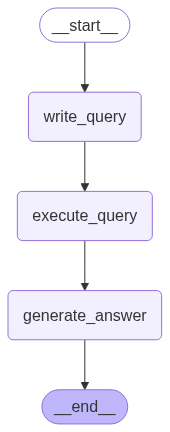

In [61]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [62]:
query = {"question": "How many employees are there?"}
for step in graph.stream(query, stream_mode="updates"):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) AS num_employees FROM Employee;'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': '<think>\nOkay, let\'s see. The user asked, "How many employees are there?" So they want to know the total number of employees in the database.\n\nThe SQL query provided is SELECT COUNT(*) AS num_employees FROM Employee;. That makes sense because COUNT(*) counts all rows in the Employee table, which should correspond to the number of employees. The result from the SQL query is [(8,)], which means the count is 8.\n\nSo the answer should be straightforward. The query executed and returned 8 as the number of employees. I just need to present that result in a clear way. The user probably just needs a direct answer without any extra explanation, but since they asked for the answer in the box, I\'ll make sure to state it clearly.\n</think>\n\nThe SQL query executed successfully and returned a result of `8`. Therefore, the answer to the question 

## LangGraph Agent 

In [63]:
from langchain import hub 

prompt = hub.pull("langchain-ai/sql-agent-system-prompt")

In [64]:
prompt.messages[0].pretty_print()

================================ System Message ================================

You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run, then look at the results of the query and return the answer.
Unless the user specifies a specific number of examples they wish to obtain, always limit your query to at most {top_k} results.
You can order the results by a relevant column to return the most interesting examples in the database.
Never query for all the columns from a specific table, only ask for the relevant columns given the question.
You have access to tools for interacting with the database.
Only use the below tools. Only use the information returned by the below tools to construct your final answer.
You MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to th

In [65]:
system_prompt = prompt.invoke({"dialect": db.dialect, "top_k": 5})
system_prompt = prompt.format(dialect = db.dialect, top_k = 5)

In [66]:
system_prompt

'System: You are an agent designed to interact with a SQL database.\nGiven an input question, create a syntactically correct sqlite query to run, then look at the results of the query and return the answer.\nUnless the user specifies a specific number of examples they wish to obtain, always limit your query to at most 5 results.\nYou can order the results by a relevant column to return the most interesting examples in the database.\nNever query for all the columns from a specific table, only ask for the relevant columns given the question.\nYou have access to tools for interacting with the database.\nOnly use the below tools. Only use the information returned by the below tools to construct your final answer.\nYou MUST double check your query before executing it. If you get an error while executing a query, rewrite the query and try again.\n\nDO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.\n\nTo start you should ALWAYS look at the tables in the datab

In [67]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

In [68]:
toolkit.get_context()

{'table_info': '\nCREATE TABLE "Album" (\n\t"AlbumId" INTEGER NOT NULL, \n\t"Title" NVARCHAR(160) NOT NULL, \n\t"ArtistId" INTEGER NOT NULL, \n\tPRIMARY KEY ("AlbumId"), \n\tFOREIGN KEY("ArtistId") REFERENCES "Artist" ("ArtistId")\n)\n\n/*\n3 rows from Album table:\nAlbumId\tTitle\tArtistId\n1\tFor Those About To Rock We Salute You\t1\n2\tBalls to the Wall\t2\n3\tRestless and Wild\t2\n*/\n\n\nCREATE TABLE "Artist" (\n\t"ArtistId" INTEGER NOT NULL, \n\t"Name" NVARCHAR(120), \n\tPRIMARY KEY ("ArtistId")\n)\n\n/*\n3 rows from Artist table:\nArtistId\tName\n1\tAC/DC\n2\tAccept\n3\tAerosmith\n*/\n\n\nCREATE TABLE "Customer" (\n\t"CustomerId" INTEGER NOT NULL, \n\t"FirstName" NVARCHAR(40) NOT NULL, \n\t"LastName" NVARCHAR(20) NOT NULL, \n\t"Company" NVARCHAR(80), \n\t"Address" NVARCHAR(70), \n\t"City" NVARCHAR(40), \n\t"State" NVARCHAR(40), \n\t"Country" NVARCHAR(40), \n\t"PostalCode" NVARCHAR(10), \n\t"Phone" NVARCHAR(24), \n\t"Fax" NVARCHAR(24), \n\t"Email" NVARCHAR(60) NOT NULL, \n\t"Supp

In [69]:
tools = toolkit.get_tools()
tools

[QuerySQLDatabaseTool(description="Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.", db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C291DD9BD0>),
 InfoSQLDatabaseTool(description='Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3', db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C291DD9BD0>),
 ListSQLDatabaseTool(db=<langchain_community.utilities.sql_database.SQLDatabase object at 0x000001C291DD9BD0>),
 QuerySQLCheckerTool(description='Use this tool to 

In [70]:
tools[0].invoke("select * from Album limit 2")

"[(1, 'For Those About To Rock We Salute You', 1), (2, 'Balls to the Wall', 2)]"

In [71]:
# print(tools[1].invoke("Album, Customer"))

## Agent

In [72]:
from langgraph.prebuilt import create_react_agent
from langchain_core.messages import HumanMessage 

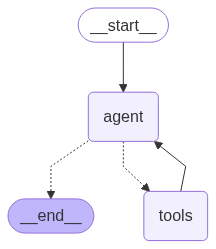

In [73]:
agent_executor = create_react_agent(llm, tools)
display(Image(agent_executor.get_graph().draw_mermaid_png())) 

In [77]:
question = "What are the titles of the albums?"
query = {"messages": [HumanMessage(question)]}

for step in agent_executor.stream(query, stream_mode="updates"):
    print(step)
    # step['messages'][-1].pretty_print()

{'agent': {'messages': [AIMessage(content="<think>\nOkay, the user is asking for the titles of the albums. First, I need to figure out which table and columns are relevant. Since they mentioned albums, there's probably a table like 'albums' or maybe 'music' or something similar. But I don't know the exact structure yet.\n\nI should start by checking the available tables in the database. The sql_db_list_tables function can help with that. Let me call that first. Once I have the list of tables, I can determine which one contains album information. \n\nAssuming there's an 'albums' table, the next step is to check its schema using sql_db_schema. This will show me the columns, so I can find the correct column name for the title, maybe 'title' or 'album_title'. \n\nAfter knowing the correct column name, I can construct an SQL query to select the titles from the albums table. Before executing, I should use sql_db_query_checker to ensure the query is correct. If there's an error, like an unkno

In [86]:
def extract_final_answer(agent_output):
    """Smart extraction of the clean final answer from any agent output structure"""
    if isinstance(agent_output, dict) and 'agent' in agent_output:
        last_message = agent_output['agent']['messages'][-1]
        if hasattr(last_message, 'content'):
            # Remove all XML/thinking tags and their content
            import re
            clean_content = re.sub(r'<think>.*?</think>', '', last_message.content, flags=re.DOTALL)
            
            # Remove empty lines and excessive whitespace
            clean_content = '\n'.join(
                line.strip() for line in clean_content.split('\n') 
                if line.strip()
            )
            
            # Remove any remaining JSON/technical artifacts
            clean_content = re.sub(r'\{.*?\}|\[.*?\]|\(.*?\)', '', clean_content)
            
            return clean_content.strip()
    return None

# Main processing
question = "How many tracks are there?"
query = {"messages": [HumanMessage(question)]}

for step in agent_executor.stream(query, stream_mode="updates"):
    final_answer = extract_final_answer(step)
    if final_answer:
        print(final_answer)
        break  # Stop after getting the first valid answer

There are **3,503 tracks** in the database.
